# Prompt Optimisation

As your system built on AgentX goes to production, whether it is using the Agent class or publishing Tool to the store, you will accumulate more and more feedback data. Utilising these data, you can tune the prompt and the inference hyperparameters to achieve elevated performance.

This notebook demonstrate how to tune prompt and the inference hyperparameters to better predict the salary range of a job posting based on its job description, which can be used to help job seekers and hiring managers to better understand the job market.

In [1]:
# Data sourced from https://www.kaggle.com/datasets/arshkon/linkedin-job-postings
# CC BY-SA 4.0 license
# Data cleaned and filtered by Chan Ka Hei
import json
from pandas import read_parquet
from rich import print as rich_print

dataset = read_parquet(
    'data/job_posting_2023.parquet'
)

dataset.head()

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped,salary,short_description,skill_set
20487,3701151544,20122211.0,Senior Litigation Attorney/Special Assistant A...,SENIOR LITIGATION ATTORNEY/SPECIAL ASSISTANT A...,128252.0,NaN,111251.0,YEARLY,Full-time,"Providence, RI",...,1.692730e+12,None,1,FULL_TIME,USD,BASE_SALARY,1,119751.5,The Rhode Island Office of the Attorney Genera...,"[""Trial experience"", ""Supervisory experience"",..."
25611,3697340789,90639.0,Site Civil Engineer,Green Key is looking for a strong site design ...,120000.0,NaN,100000.0,YEARLY,Full-time,"New York, NY",...,1.692730e+12,None,1,FULL_TIME,USD,BASE_SALARY,1,110000.0,Green Key is seeking a Civil Engineer with exp...,"[""Autocad"", ""Civil 3D"", ""Stormwater management..."
22215,3699085089,1441.0,"Software Engineering Manager II, Google Cloud ...",Note: By applying to this position you will ha...,283000.0,NaN,185000.0,YEARLY,Full-time,"Seattle, WA",...,1.692830e+12,careers.google.com,1,FULL_TIME,USD,BASE_SALARY,1,234000.0,"Like Google's own ambitions, the work of a Sof...","[""Bachelor\u2019s degree or equivalent practic..."
821,3757776363,2908367.0,Licensed Journeyman Electician,Gpac just partnered with a super company to fi...,100000.0,NaN,70000.0,YEARLY,Full-time,"San Diego, CA",...,1.699070e+12,usa.applybe.com,0,FULL_TIME,USD,BASE_SALARY,1699138477,85000.0,Gpac has partnered with a company to find Sola...,"[""Journeyman Electrician license"", ""At least 3..."
7506,3757446699,8052981.0,Senior Buyer,"ObjectiveBroadband Telecom Power, an EV chargi...",90000.0,NaN,80000.0,YEARLY,Full-time,"Santa Ana, CA",...,1.699040e+12,None,0,FULL_TIME,USD,BASE_SALARY,1699039150,85000.0,"Broadband Telecom Power, an EV charging equipm...","[""Bachelor's Degree in Business, Engineering o..."


In [2]:
# We will use 'salary' as our target variable.
# We will use 'title', 'short_description', 'skill_set', 'location', 'formatted_experience_level' as our input variable.

# Remove curreny other than USD
dataset.skill_set = dataset.skill_set.apply(lambda x: json.loads(x))
x = dataset[
    [
        'title', 
        'short_description',
        'skill_set',
        'location', 
        'formatted_experience_level', 
    ]
].to_dict(orient='records')


y = dataset['salary'].to_list()

In [3]:
# Use AgentX to generate a model that can predict salary based on job title, description, location, and experience level.
# This will be the baseline of the optimisation process.

from agentx.agent import Agent
from agentx.schema import GenerationConfig, Message, Content
from dotenv import load_dotenv
from random import sample
from typing import List, Union
from pydantic import BaseModel
import os
import asyncio

load_dotenv()

class JobPost(BaseModel):
    title: str
    short_description: str
    skill_set: List[str]
    location: Union[str, None]
    formatted_experience_level: Union[str, None]

class SalaryPrediction(BaseModel):
    reasons: str
    salary: int

generation_config = GenerationConfig(
    api_type='azure',
    api_key=os.environ.get('AZURE_OPENAI_KEY'),
    base_url=os.environ.get('AZURE_OPENAI_ENDPOINT'),
    azure_deployment='gpt-35',
)

salary_prediction_agent = Agent(
    name='salary_prediction',
    generation_config=generation_config,
    system_prompt='''You will predict the salary of a job posting based on the job title, description, location, and experience level.
Output JSON format only.''',
)

# sample a small test set
test_set_ids = sample(range(len(x)), 50)
rich_print(x[test_set_ids[0]])
rich_print(y[test_set_ids[0]])

{
    'title': 'Senior Accountant, MFG in Glendale Hts, Primarily On-site, $85k-$95k',
    'short_description': 'Senior Accountant reporting directly to the Corporate Controller. Position will require 
person to adapt to a variety of situations both domestic and international. Primary Responsibilities: Perform 
account reconciliations and analysis of multi-currency intercompany transactions; Communication with international 
accounting staff; Prepare company-wide consolidated financial statements and cash flows; Prepare and maintain books
and records for company divisions; Assist and support the cost accounting functions, including preparation of labor
and overhead updates; Prepare and file various state tax returns, including sales and use tax; Assist in 
preparation of audit support schedules; Assist in preparation of the consolidated tax return; Assist with internal 
audit travel assignments to international locations.',
    'skill_set': [
        'Accounting degree',
        'CPA preferred',
        'Accounting generalist background',
        'Audit experience preferred',
        'Sales & Use Tax experience',
        'Advanced Excel',
        'Ad Hoc reporting - Power BI'
    ],
    'location': 'Glendale Heights, IL',
    'formatted_experience_level': 'Associate'
}

90000.0

In [4]:
# perform one prediction for sanity check

response = salary_prediction_agent.generate_response(
    messages=[
        Message(
            role='user',
            content=Content(
                text=JobPost(**x[test_set_ids[0]]).model_dump_json(),
            )
        )
    ],
    output_model=SalaryPrediction,
)

In [5]:
rich_print(
    SalaryPrediction.model_validate_json(
        response.content.text
    )
)

rich_print(
    {
        'Actual Salary': y[test_set_ids[0]],
    }
)

SalaryPrediction(
    reasons='The predicted salary is based on the job title, description, location, and experience level.',
    salary=90000
)

{'Actual Salary': 90000.0}

In [6]:
from tqdm import tqdm

responses = []

# perform prediction for the test set
for index in tqdm(range(0,50,5)):
    indices = test_set_ids[index:index+5]
    _responses = await asyncio.gather(*[
        salary_prediction_agent.a_generate_response(
            messages=[
                Message(
                    role='user',
                    content=Content(
                        text=JobPost(**datum).model_dump_json(),
                    )
                )
            ],
            output_model=SalaryPrediction
        ) for datum in [x[i] for i in indices]
    ])
    responses.extend(_responses)
    # avoid rate limiting error
    await asyncio.sleep(5)

responses = [SalaryPrediction.model_validate_json(response.content.text) if response != None else None for response in responses]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:10<00:00,  7.07s/it]


In [33]:
# Let's check how well the agent did
import numpy as np

def metric(predicted:List[Union[SalaryPrediction, None]], truth:List[float]):
    if len(predicted) != len(truth):
        raise ValueError('predicted and actual must be the same length')

    drop_na = [(p, a) for p, a in zip(predicted, truth) if p != None]
    _predicted = [d[0].salary for d in drop_na]
    _truth = [d[1] for d in drop_na]
    
    p = np.array([_predicted])
    t = np.array([_truth])
    
    rmse = np.sqrt(np.mean(np.square(p - t)))
    return rmse

rmse = metric(
    responses,
    [y[i] for i in test_set_ids]
)

rich_print('Root mean square error: {rmse} USD'.format(rmse=rmse))
rich_print('Average salary sange in the dataset: {avg} USD'.format(avg=np.mean(np.subtract(dataset.max_salary,dataset.min_salary))))

Root mean square error: 36163.482046885845 USD

Average salary sange in the dataset: 37361.097090012336 USD

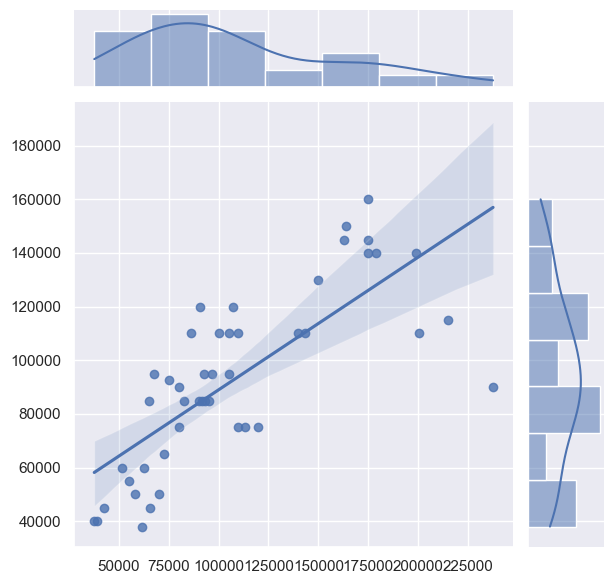

In [29]:
# The agent's error is already within the average salary range in the dataset.
# Let's visualize the baseline performace with a scatter plot

import seaborn as sns
sns.set_theme(style="darkgrid")

drop_na = [(p, a) for p, a in zip(responses, [y[i] for i in test_set_ids]) if p != None]
_predicted = [float(d[0].salary) for d in drop_na]
_truth = [d[1] for d in drop_na]

sns.jointplot(
    x=_truth,
    y=_predicted,
    kind='reg',
)

In [27]:
# Attempts to improve the agent's performance by using textual gradient descent

from agentx.optimisers import TextualGradientPromptTrainer

reviewer = Agent(
    name='reviewer',
    generation_config=generation_config,
    system_prompt='You are a prompt engineer. Review the given prompt, error samples and give reasons why the prompt have gotten these examples wrong.',
)

def textual_gradient(
    prompt:str,
    input:List[JobPost],
    predicted:List[Union[SalaryPrediction, None]],
    truth:List[float],
) -> List[Message]:
    errors = [
        {
            'input': input.model_dump(),
            'predicted': predicted.salary if predicted != None else None,
            'truth': truth,
        } for input, predicted, truth in zip(input, predicted, truth) if predicted != int(truth)
    ]

    messages = [
        Message(
            role='user',
            content=Content(
                text='''Current prompt: {prompt}

Errors: {errors}'''.format(prompt=prompt, errors=errors, )
            ),
        )
    ]

    response = reviewer.generate_response(
        messages=messages
    )
    
    return messages + [response]

In [29]:
# test the textual_gradient
gradient = textual_gradient(
    prompt=sentiment_classification_agent.system_prompt,
    input=[datum['title'] for datum in test_set],
    predicted=[PricePrediction.model_validate_json(response.content.text) for response in responses],
    truth=[PricePrediction(movement=datum.get('price_movement')) for datum in test_set],
)

In [30]:
rich_print(gradient[-1].content.text)

The given prompt has several issues that have led to incorrect predictions. Here are the reasons why the prompt has
gotten these examples wrong:

1. Over-reliance on headline sentiment: The prompt solely relies on news headlines to predict the price movement of
QQQ. However, headlines can sometimes be misleading or not fully representative of the market sentiment. It is 
important to consider more comprehensive financial data and market analysis rather than just relying on news 
headlines.

2. Lack of context: News headlines alone may not provide sufficient context for predicting price movements 
accurately. Market movements are influenced by a wide range of factors including economic indicators, company 
performance, geopolitical events, and investor sentiment. Without considering these broader contextual factors, it 
is challenging to make accurate predictions solely based on news headlines.

3. Ambiguity in price movement definition: The prompt defines price movement as positive, negative, or neutral, 
without specifying the degree of movement that would be considered substantial. This lack of specificity can lead 
to subjective interpretations and inconsistent predictions.

4. Inconsistent correlation between news and price movement: The examples demonstrate instances where the predicted
price movement based on headlines does not align with the actual price movement. This inconsistency highlights the 
limitations of using news headlines as the sole basis for price predictions.

To improve the accuracy of predictions, the prompt should incorporate broader financial data, market analysis, and 
contextual factors, while also defining clear criteria for price movement predictions.

In [ ]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler